## Content
This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

## import libraries

In [ ]:
# Manpulate
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Feature Extraction
import user_agents # get info from user_agent (browser_info)
from ip2geotools.databases.noncommercial import DbIpCity as ip2geo # get location from ip
from geopy.distance import great_circle # distance btn 2 (lat,long)
from geopy.geocoders import Nominatim # geocode("place") / reverse("lat,long")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # text feature

# Pre-Processing
from sklearn.model_selection import train_test_split # train-test-split
from sklearn.impute import SimpleImputer, KNNImputer # detect & handle NaNs
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder # Ordinal Encoding, Nominal Encoding
from category_encoders import BinaryEncoder # Nominal Encoding 
from imblearn.under_sampling import RandomUnderSampler # undersampling
from imblearn.over_sampling import RandomOverSampler, SMOTE # oversampling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # Scaling

# Modeling
## 1) Pipeline
from sklearn.pipeline import Pipeline, make_pipeline # to make pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector # apply pipeline to each column

## 2) Regression Models
from sklearn.linear_model import LinearRegression # if data is small and small_no_features
from sklearn.linear_model import SGDRegressor # if data is large: (can have penalty=constrains)
from sklearn.preprocessing import PolynomialFeatures # for polynomial regresion (then apply scaling after it)
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV # Regularization 

## 3) Model Selection (Underfitting vs Overfitting) [bias variance tradeoff => perfect model complexity]
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV # (Train - Valid - Test) + hyperparameters tunning 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV # if data / features is large
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error # Evaluate Model: r2=> accuracy, L2-norm: if no outliers, L1-norm: if outliers
from scipy import stats # Confidence Interval of Accuracy / Loss / Utility
import joblib # save model

## (1) Understanding Data
a) Understand Columns

b) check dtype -> df[col].astype()

c) Describe Numerical Cols

d) Describe Categorical Cols

In [ ]:
# (a) understand columns.
df = pd.read_csv("Churn_Modelling.csv")
df

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0          2       0.00              1          1               1   
1          1   83807.86              1          0               1   
2          8  159660.80              3          1               0   
3          1       0.00              2          0               0   
4          2  125510.82              1          1               1   
...      ...        ...            ...        ...             ...   
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
0           101348.88       1  
1           112542.58       0  
2           113931.57       1  
3            93826.63       0  
4            79084.10       0  
...               ...     ...  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0  

[10000 rows x 14 columns]

In [ ]:
# (b) check type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# (c) Describe Numerical Cols
df.describe()

RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count     10000.000000  10000.000000  
mean     100090.239881      0.203700  
std       57510.492818      0.402769  
min          11.580000      0.000000  
25%       51002.110000      0.000000  
50%      100193.915000      0.000000  
75%      149388.247500      0.000000  
max      199992.480000      1.000000

In [ ]:
# After numerical describe min = 11.580000 it is unrealistic number so 
df[df['EstimatedSalary'] < 100]

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
2362       2363    15791053  Lucciano          709   Germany    Male   45   
5548       5549    15639662  Phillips          710    France    Male   38   
9010       9011    15786463     Hsing          645   Germany  Female   59   
9647       9648    15679693    Walker          625    France    Male   31   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
2362       4  122917.71              1          1               1   
5548       2       0.00              2          1               0   
9010       8  121669.93              2          0               0   
9647       5       0.00              2          0               1   

      EstimatedSalary  Exited  
2362            11.58       1  
5548            96.27       0  
9010            91.75       1  
9647            90.07       0

In [ ]:
df[(df['EstimatedSalary'] < 100) & (df['Balance'] > 100e3)]

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
2362       2363    15791053  Lucciano          709   Germany    Male   45   
9010       9011    15786463     Hsing          645   Germany  Female   59   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
2362       4  122917.71              1          1               1   
9010       8  121669.93              2          0               0   

      EstimatedSalary  Exited  
2362            11.58       1  
9010            91.75       1

In [ ]:
# droped them (2 undertermined points)

remove_idx = df[(df['EstimatedSalary'] < 100) & (df['Balance'] > 100e3)].index

df.drop(remove_idx, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
df

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9993       9996    15606229   Obijiaku          771    France    Male   39   
9994       9997    15569892  Johnstone          516    France    Male   35   
9995       9998    15584532        Liu          709    France  Female   36   
9996       9999    15682355  Sabbatini          772   Germany    Male   42   
9997      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0          2       0.00              1          1               1   
1          1   83807.86              1          0               1   
2          8  159660.80              3          1               0   
3          1       0.00              2          0               0   
4          2  125510.82              1          1               1   
...      ...        ...            ...        ...             ...   
9993       5       0.00              2          1               0   
9994      10   57369.61              1          1               1   
9995       7       0.00              1          0               1   
9996       3   75075.31              2          1               0   
9997       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
0           101348.88       1  
1           112542.58       0  
2           113931.57       1  
3            93826.63       0  
4            79084.10       0  
...               ...     ...  
9993         96270.64       0  
9994        101699.77       0  
9995         42085.58       1  
9996         92888.52       1  
9997         38190.78       0  

[9998 rows x 14 columns]

In [ ]:
df.describe()

RowNumber    CustomerId  CreditScore          Age       Tenure  \
count   9998.000000  9.998000e+03  9998.000000  9998.000000  9998.000000   
mean    5000.362673  1.569092e+07   650.523505    38.919184     5.012603   
std     2886.785277  7.193007e+04    96.661182    10.486756     2.892292   
min        1.000000  1.556570e+07   350.000000    18.000000     0.000000   
25%     2501.250000  1.562852e+07   584.000000    32.000000     3.000000   
50%     5000.500000  1.569073e+07   652.000000    37.000000     5.000000   
75%     7499.750000  1.575321e+07   718.000000    44.000000     7.000000   
max    10000.000000  1.581569e+07   850.000000    92.000000    10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count    9998.000000    9998.000000  9998.000000     9998.000000   
mean    76476.725869       1.530206     0.705541        0.515103   
std     62400.281536       0.581669     0.455822        0.499797   
min         0.000000       1.000000     0.000000        0.000000   
25%         0.000000       1.000000     0.000000        0.000000   
50%     97173.290000       1.000000     1.000000        1.000000   
75%    127647.840000       2.000000     1.000000        1.000000   
max    250898.090000       4.000000     1.000000        1.000000   

       EstimatedSalary       Exited  
count      9998.000000  9998.000000  
mean     100110.251598     0.203541  
std       57498.834155     0.402651  
min          90.070000     0.000000  
25%       51036.905000     0.000000  
50%      100218.210000     0.000000  
75%      149395.882500     0.000000  
max      199992.480000     1.000000

In [ ]:
# (d) Describe Categorical Cols

cat_cols = df.select_dtypes(include="O").columns

for col in cat_cols:
    print(f"number of uniques of \'{col}\' is: {df[col].nunique()}")
    print(f"uniques of \'{col}\' is:\n{df[col].unique()}")
    print()
    print('*' * 50)
    print()

number of uniques of 'Surname' is: 2932
uniques of 'Surname' is:
['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

**************************************************

number of uniques of 'Geography' is: 3
uniques of 'Geography' is:
['France' 'Spain' 'Germany']

**************************************************

number of uniques of 'Gender' is: 2
uniques of 'Gender' is:
['Female' 'Male']

**************************************************



In [ ]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [ ]:
# we find som unuseful data drop this data.
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France  Female   42       2       0.00              1   
1             608     Spain  Female   41       1   83807.86              1   
2             502    France  Female   42       8  159660.80              3   
3             699    France  Female   39       1       0.00              2   
4             850     Spain  Female   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9993          771    France    Male   39       5       0.00              2   
9994          516    France    Male   35      10   57369.61              1   
9995          709    France  Female   36       7       0.00              1   
9996          772   Germany    Male   42       3   75075.31              2   
9997          792    France  Female   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0             1               1        101348.88       1  
1             0               1        112542.58       0  
2             1               0        113931.57       1  
3             0               0         93826.63       0  
4             1               1         79084.10       0  
...         ...             ...              ...     ...  
9993          1               0         96270.64       0  
9994          1               1        101699.77       0  
9995          0               1         42085.58       1  
9996          1               0         92888.52       1  
9997          1               0         38190.78       0  

[9998 rows x 11 columns]

*****************************************************************

## 2) EXTRACT FEATURES + EDA (uni - bi(heatmap) - multi) -> Insights:
Uni-variate Analysis

Histogram (values)

distplot (distrbution)

catigorical (pie / count)

Bi-Variate Analysis

Num vs Num

Scatter (relationship btn 2 variables)

line (trend with time)

Num vs Cat (distrbution)

box

violin

strip

Cat vs Cat

bar (estimate plot)

countplot (count rows)

Multi-Variate Analysis

Pairplot

In [ ]:
## EXTRACT FEATURES

#(1) Financial Ratios
df['Balance_to_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
df['Credit_Score_Per_Year'] = df['CreditScore'] / df['Age']

# Categorical Groupings
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 60, np.inf], labels=['Youth', 'Adult', 'Senior'])
df['Tenure_Group'] = pd.cut(df['Tenure'], bins=[0, 3, 7, 10], labels=['New', 'Mid-Term', 'Loyal'], include_lowest=True)
df['CreditScore_Category'] = pd.cut(df['CreditScore'], bins=[0, 580, 670, 740, 800, np.inf], labels=['Low', 'Average', 'Good', 'Very Good', 'Excellent'])

# Engagement Metrics
df['Product_Engagement'] = df['NumOfProducts'] + df['IsActiveMember'] + df['HasCrCard']
df['Has_Balance'] = (df['Balance'] > 0).astype(int)

# Geography and Demographics
df['Is_French'] = (df['Geography'] == 'France').astype(int)
df['Gender_Code'] = (df['Gender'] == 'Male').astype(int)

# Interaction Features
df['CreditScore_and_Balance'] = df['CreditScore'] * df['Balance']
df['Tenure_and_Age'] = df['Tenure'] * df['Age']

# Behavioral Metrics
df['Potential_Exit_Risk'] = 1 - df['IsActiveMember'] + (1 / df['NumOfProducts'])

# Display a sample of the modified dataset
df


CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France  Female   42       2       0.00              1   
1             608     Spain  Female   41       1   83807.86              1   
2             502    France  Female   42       8  159660.80              3   
3             699    France  Female   39       1       0.00              2   
4             850     Spain  Female   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9993          771    France    Male   39       5       0.00              2   
9994          516    France    Male   35      10   57369.61              1   
9995          709    France  Female   36       7       0.00              1   
9996          772   Germany    Male   42       3   75075.31              2   
9997          792    France  Female   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  ...  Age_Group Tenure_Group  \
0             1               1        101348.88  ...      Adult          New   
1             0               1        112542.58  ...      Adult          New   
2             1               0        113931.57  ...      Adult        Loyal   
3             0               0         93826.63  ...      Adult          New   
4             1               1         79084.10  ...      Adult          New   
...         ...             ...              ...  ...        ...          ...   
9993          1               0         96270.64  ...      Adult     Mid-Term   
9994          1               1        101699.77  ...      Adult        Loyal   
9995          0               1         42085.58  ...      Adult     Mid-Term   
9996          1               0         92888.52  ...      Adult          New   
9997          1               0         38190.78  ...      Adult     Mid-Term   

      CreditScore_Category  Product_Engagement Has_Balance Is_French  \
0                  Average                   3           0         1   
1                  Average                   2           1         0   
2                      Low                   4           1         1   
3                     Good                   2           0         1   
4                Excellent                   3           1         0   
...                    ...                 ...         ...       ...   
9993             Very Good                   3           0         1   
9994                   Low                   3           1         1   
9995                  Good                   2           0         1   
9996             Very Good                   3           1         0   
9997             Very Good                   2           1         1   

     Gender_Code  CreditScore_and_Balance  Tenure_and_Age  Potential_Exit_Risk  
0              0             0.000000e+00              84             1.000000  
1              0             5.095518e+07              41             1.000000  
2              0             8.014972e+07             336             1.333333  
3              0             0.000000e+00              39             1.500000  
4              0             1.066842e+08              86             1.000000  
...          ...                      ...             ...                  ...  
9993           1             0.000000e+00             195             1.500000  
9994           1             2.960272e+07             350             1.000000  
9995           0             0.000000e+00             252             1.000000  
9996           1             5.795814e+07             126             1.500000  
9997           0             1.030731e+08             112             2.000000  

[9998 rows x 24 columns]

In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'products_engagment', 'Balance_to_Salary_Ratio',
       'Credit_Score_Per_Year', 'Age_Group', 'Tenure_Group',
       'CreditScore_Category', 'Product_Engagement', 'Has_Balance',
       'Is_French', 'Gender_Code', 'CreditScore_and_Balance', 'Tenure_and_Age',
       'Potential_Exit_Risk'],
      dtype='object')

## EDA (uni - bi(heatmap) - multi) -> Insights:
Uni-variate Analysis

Histogram (values)

distplot (distrbution)

catigorical (pie / count)

Bi-Variate Analysis

Num vs Num

Scatter (relationship btn 2 variables)

line (trend with time)

Num vs Cat (distrbution)

box

violin

strip

Cat vs Cat

bar (estimate plot)

countplot (count rows)

Multi-Variate Analysis

Pairplot

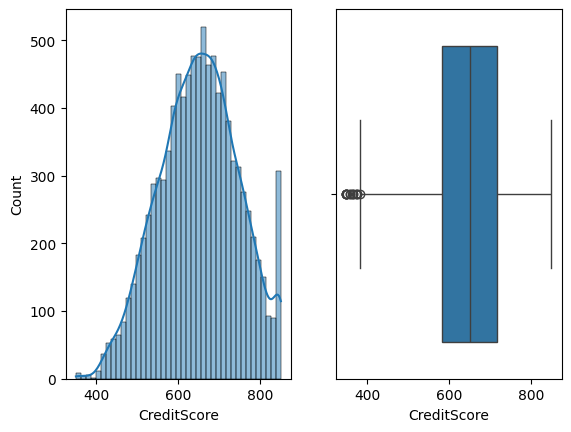

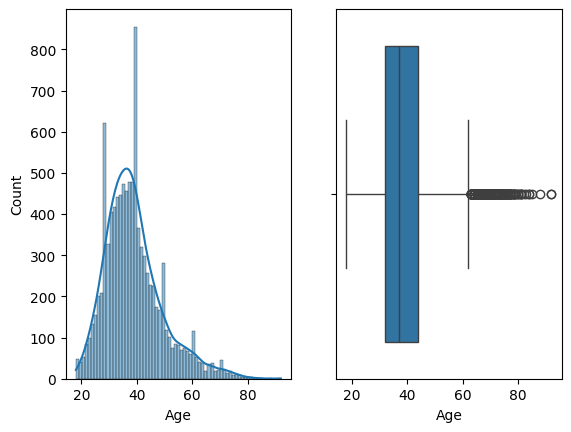

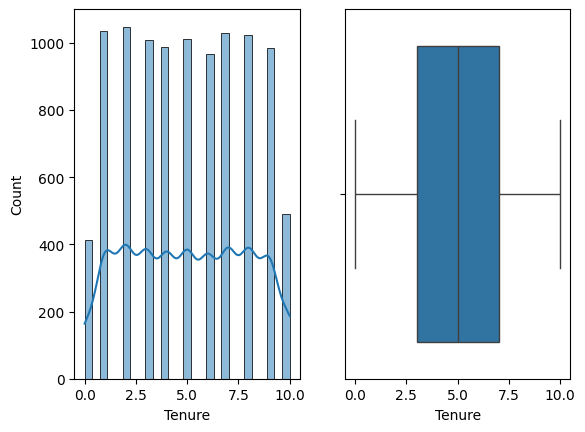

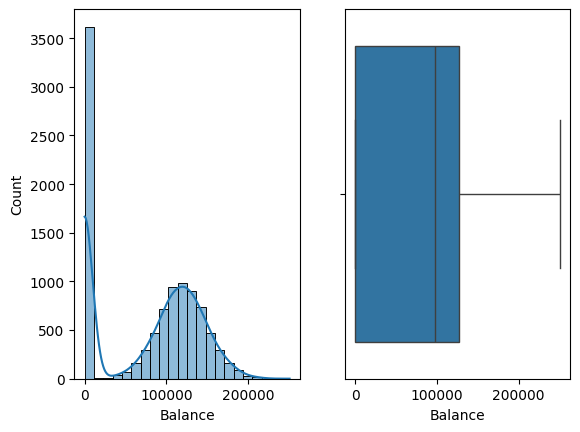

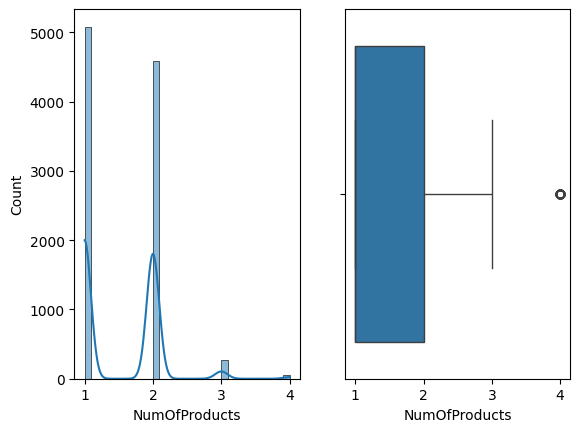

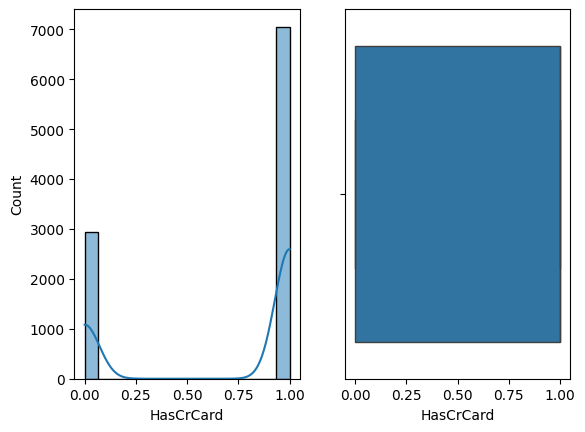

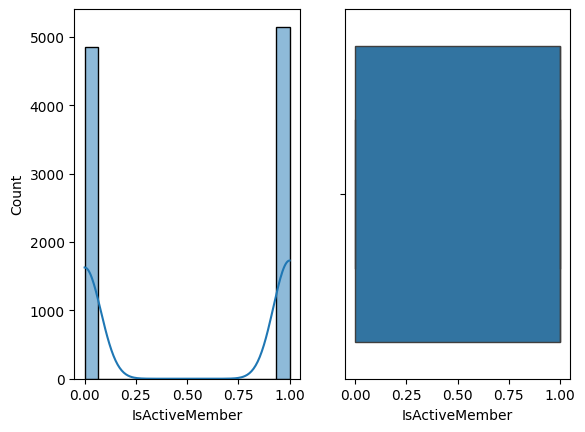

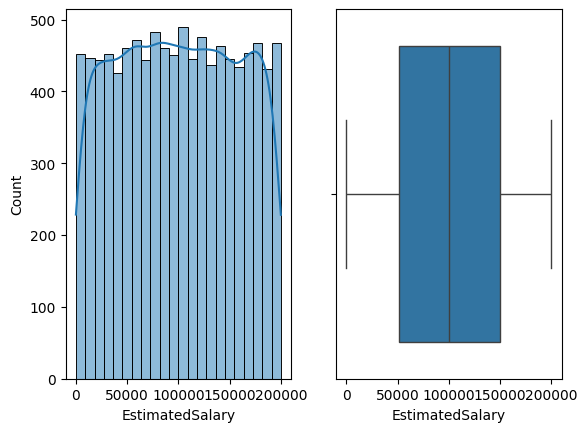

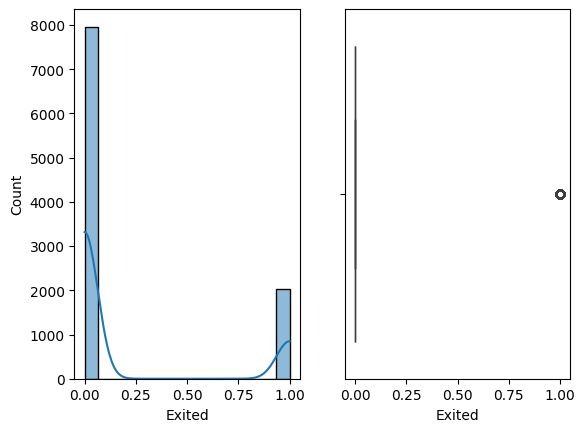

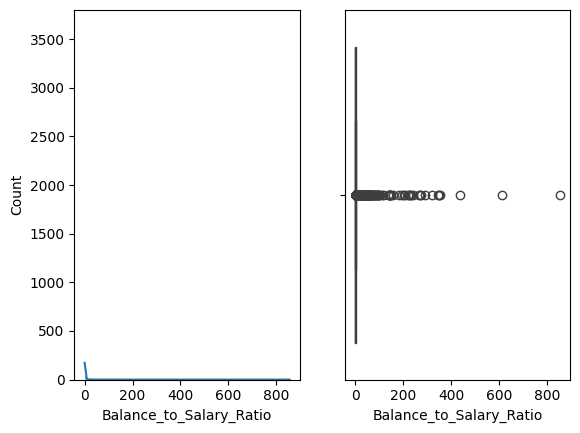

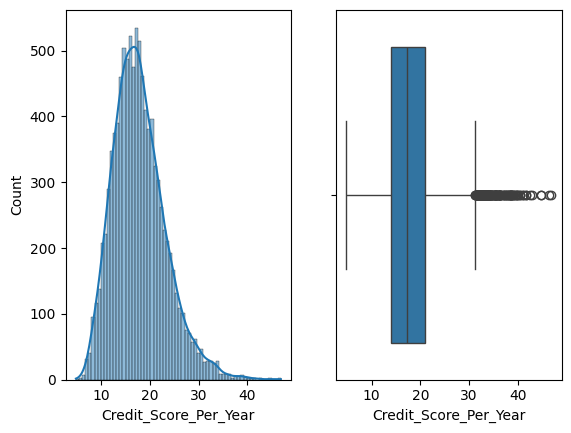

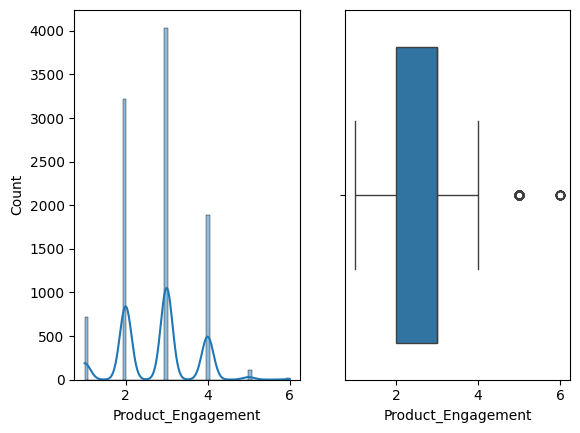

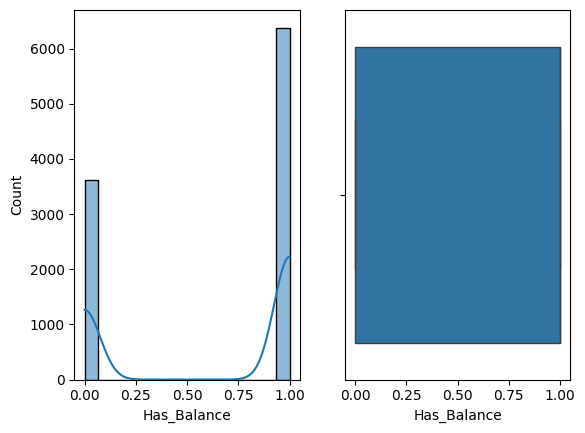

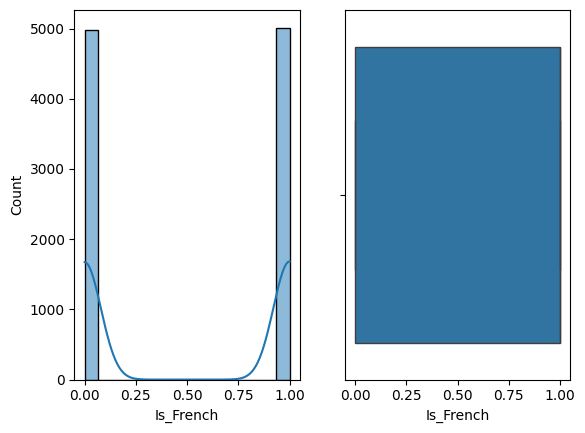

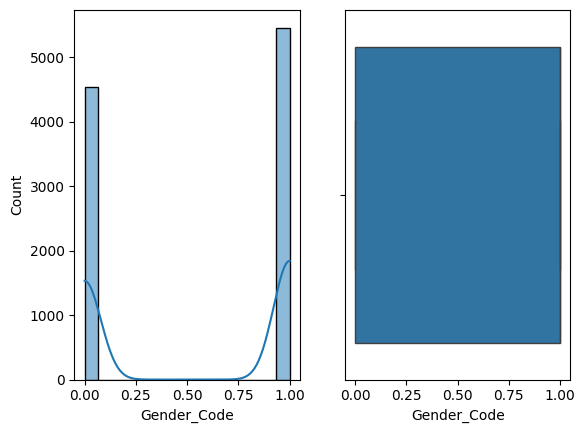

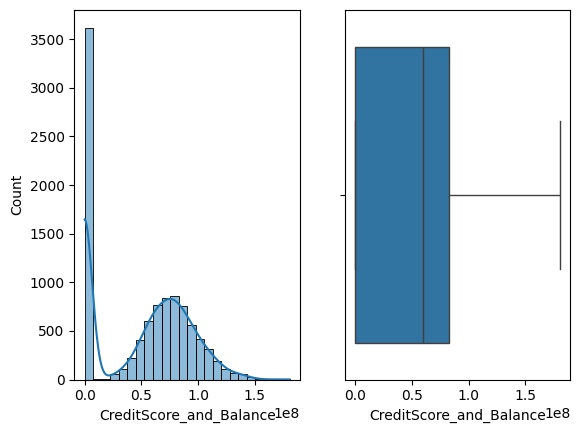

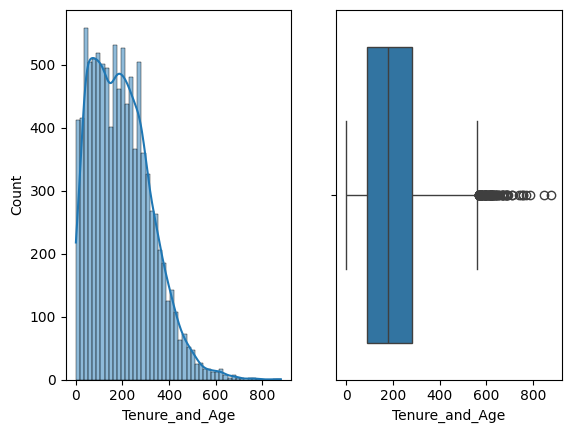

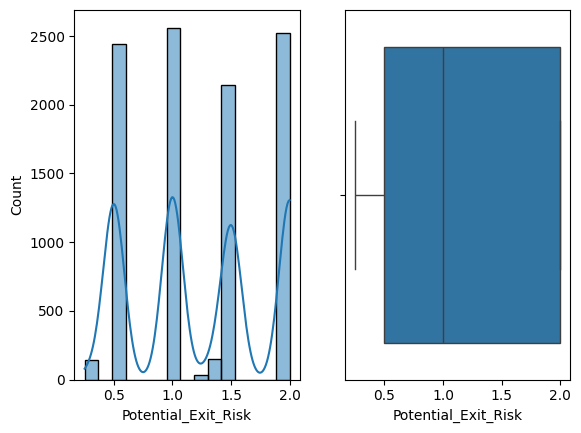

In [ ]:
# UniVariate Analysis

num_cols = df.select_dtypes(include="number").columns

for col in num_cols:
    fig, axes= plt.subplots(nrows=1, ncols=2)
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(x=df[col], ax=axes[1])
    plt.show()

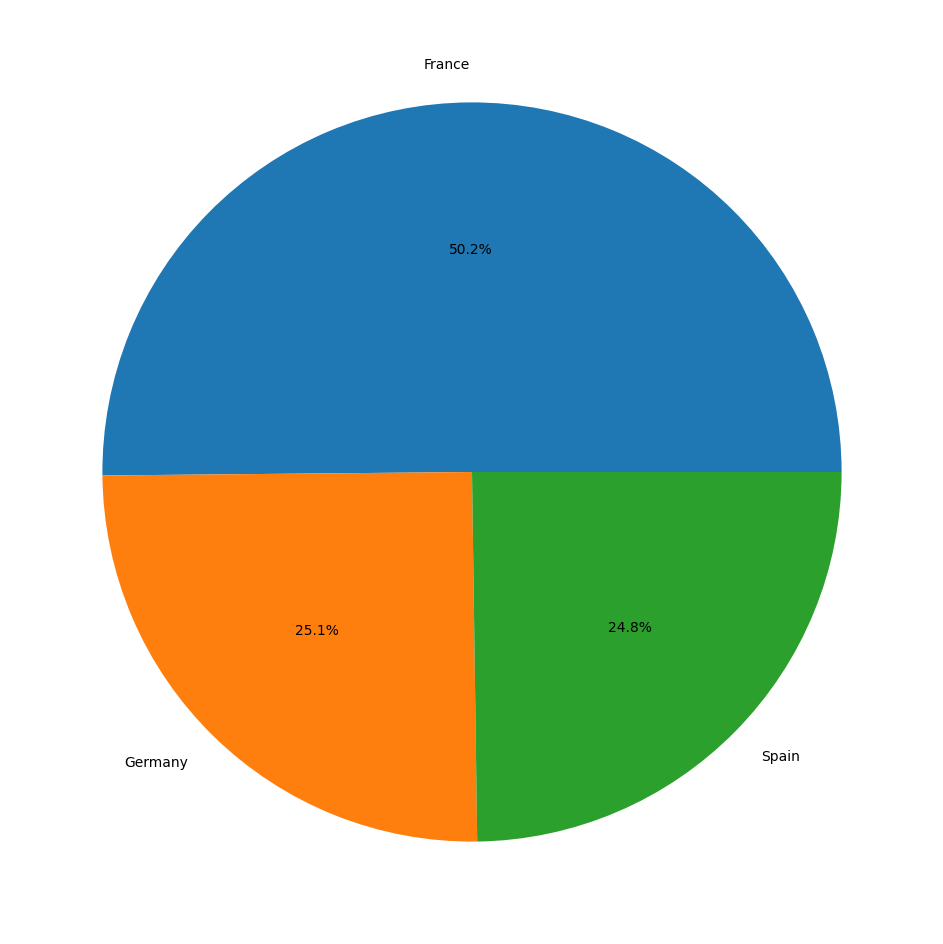

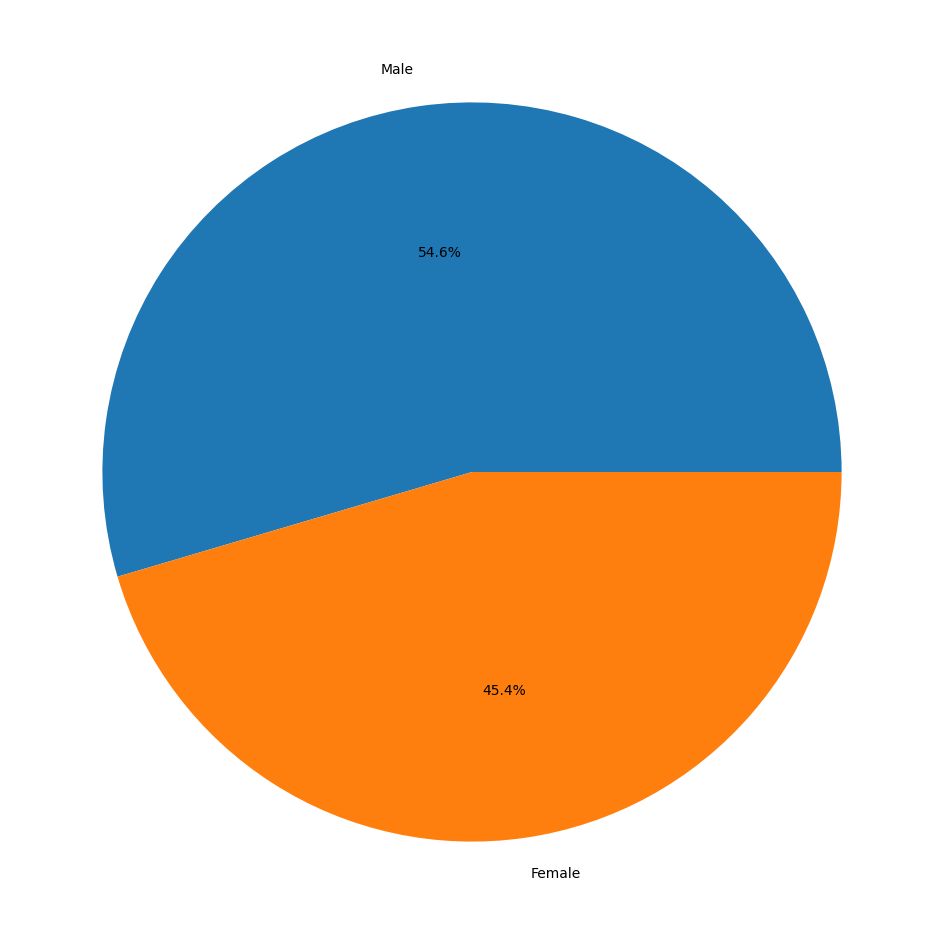

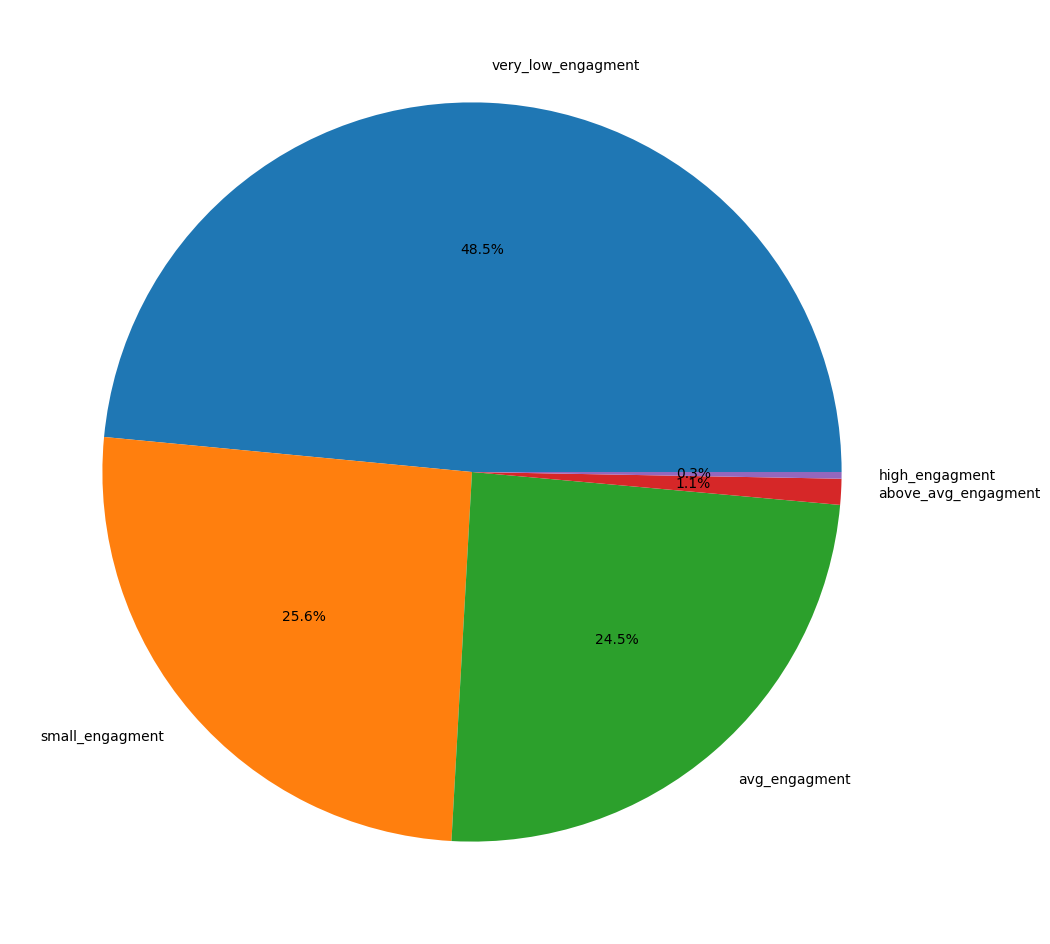

In [ ]:
cat_cols = df.select_dtypes(include='O').columns

for col in cat_cols:
    plt.figure(figsize=(22, 12))
    
    if df[col].nunique() < 7:
        dff = df.groupby(col)[['EstimatedSalary']].count().reset_index().sort_values(by='EstimatedSalary', ascending=False)
        plt.pie(labels=dff[col], x=dff['EstimatedSalary'], autopct="%1.1f%%")
        
    elif df[col].nunique() < 50:
        sns.countplot(x=df[col])

    else: # > 50 get top 10
        dff = df.groupby(col)[['EstimatedSalary']].count().reset_index().sort_values(by='EstimatedSalary', ascending=False).head(10)
        sns.countplot(x=dff[col])

    plt.show()

<Axes: >

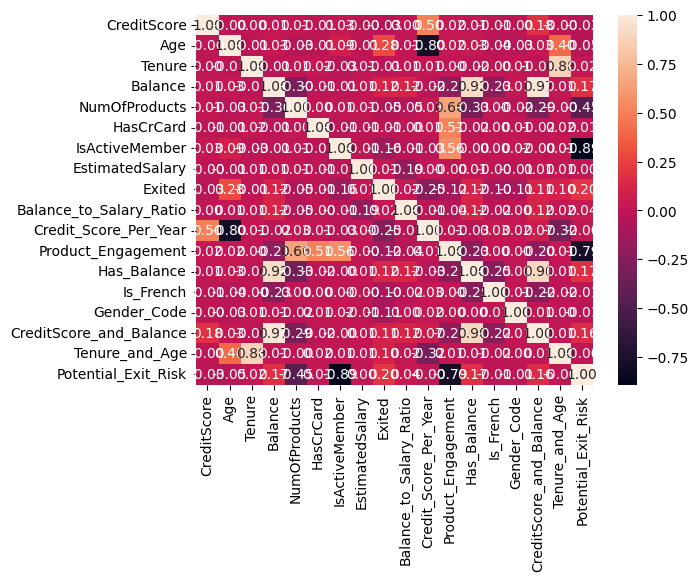

In [ ]:
# Bi-Variate

sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt='.2f')

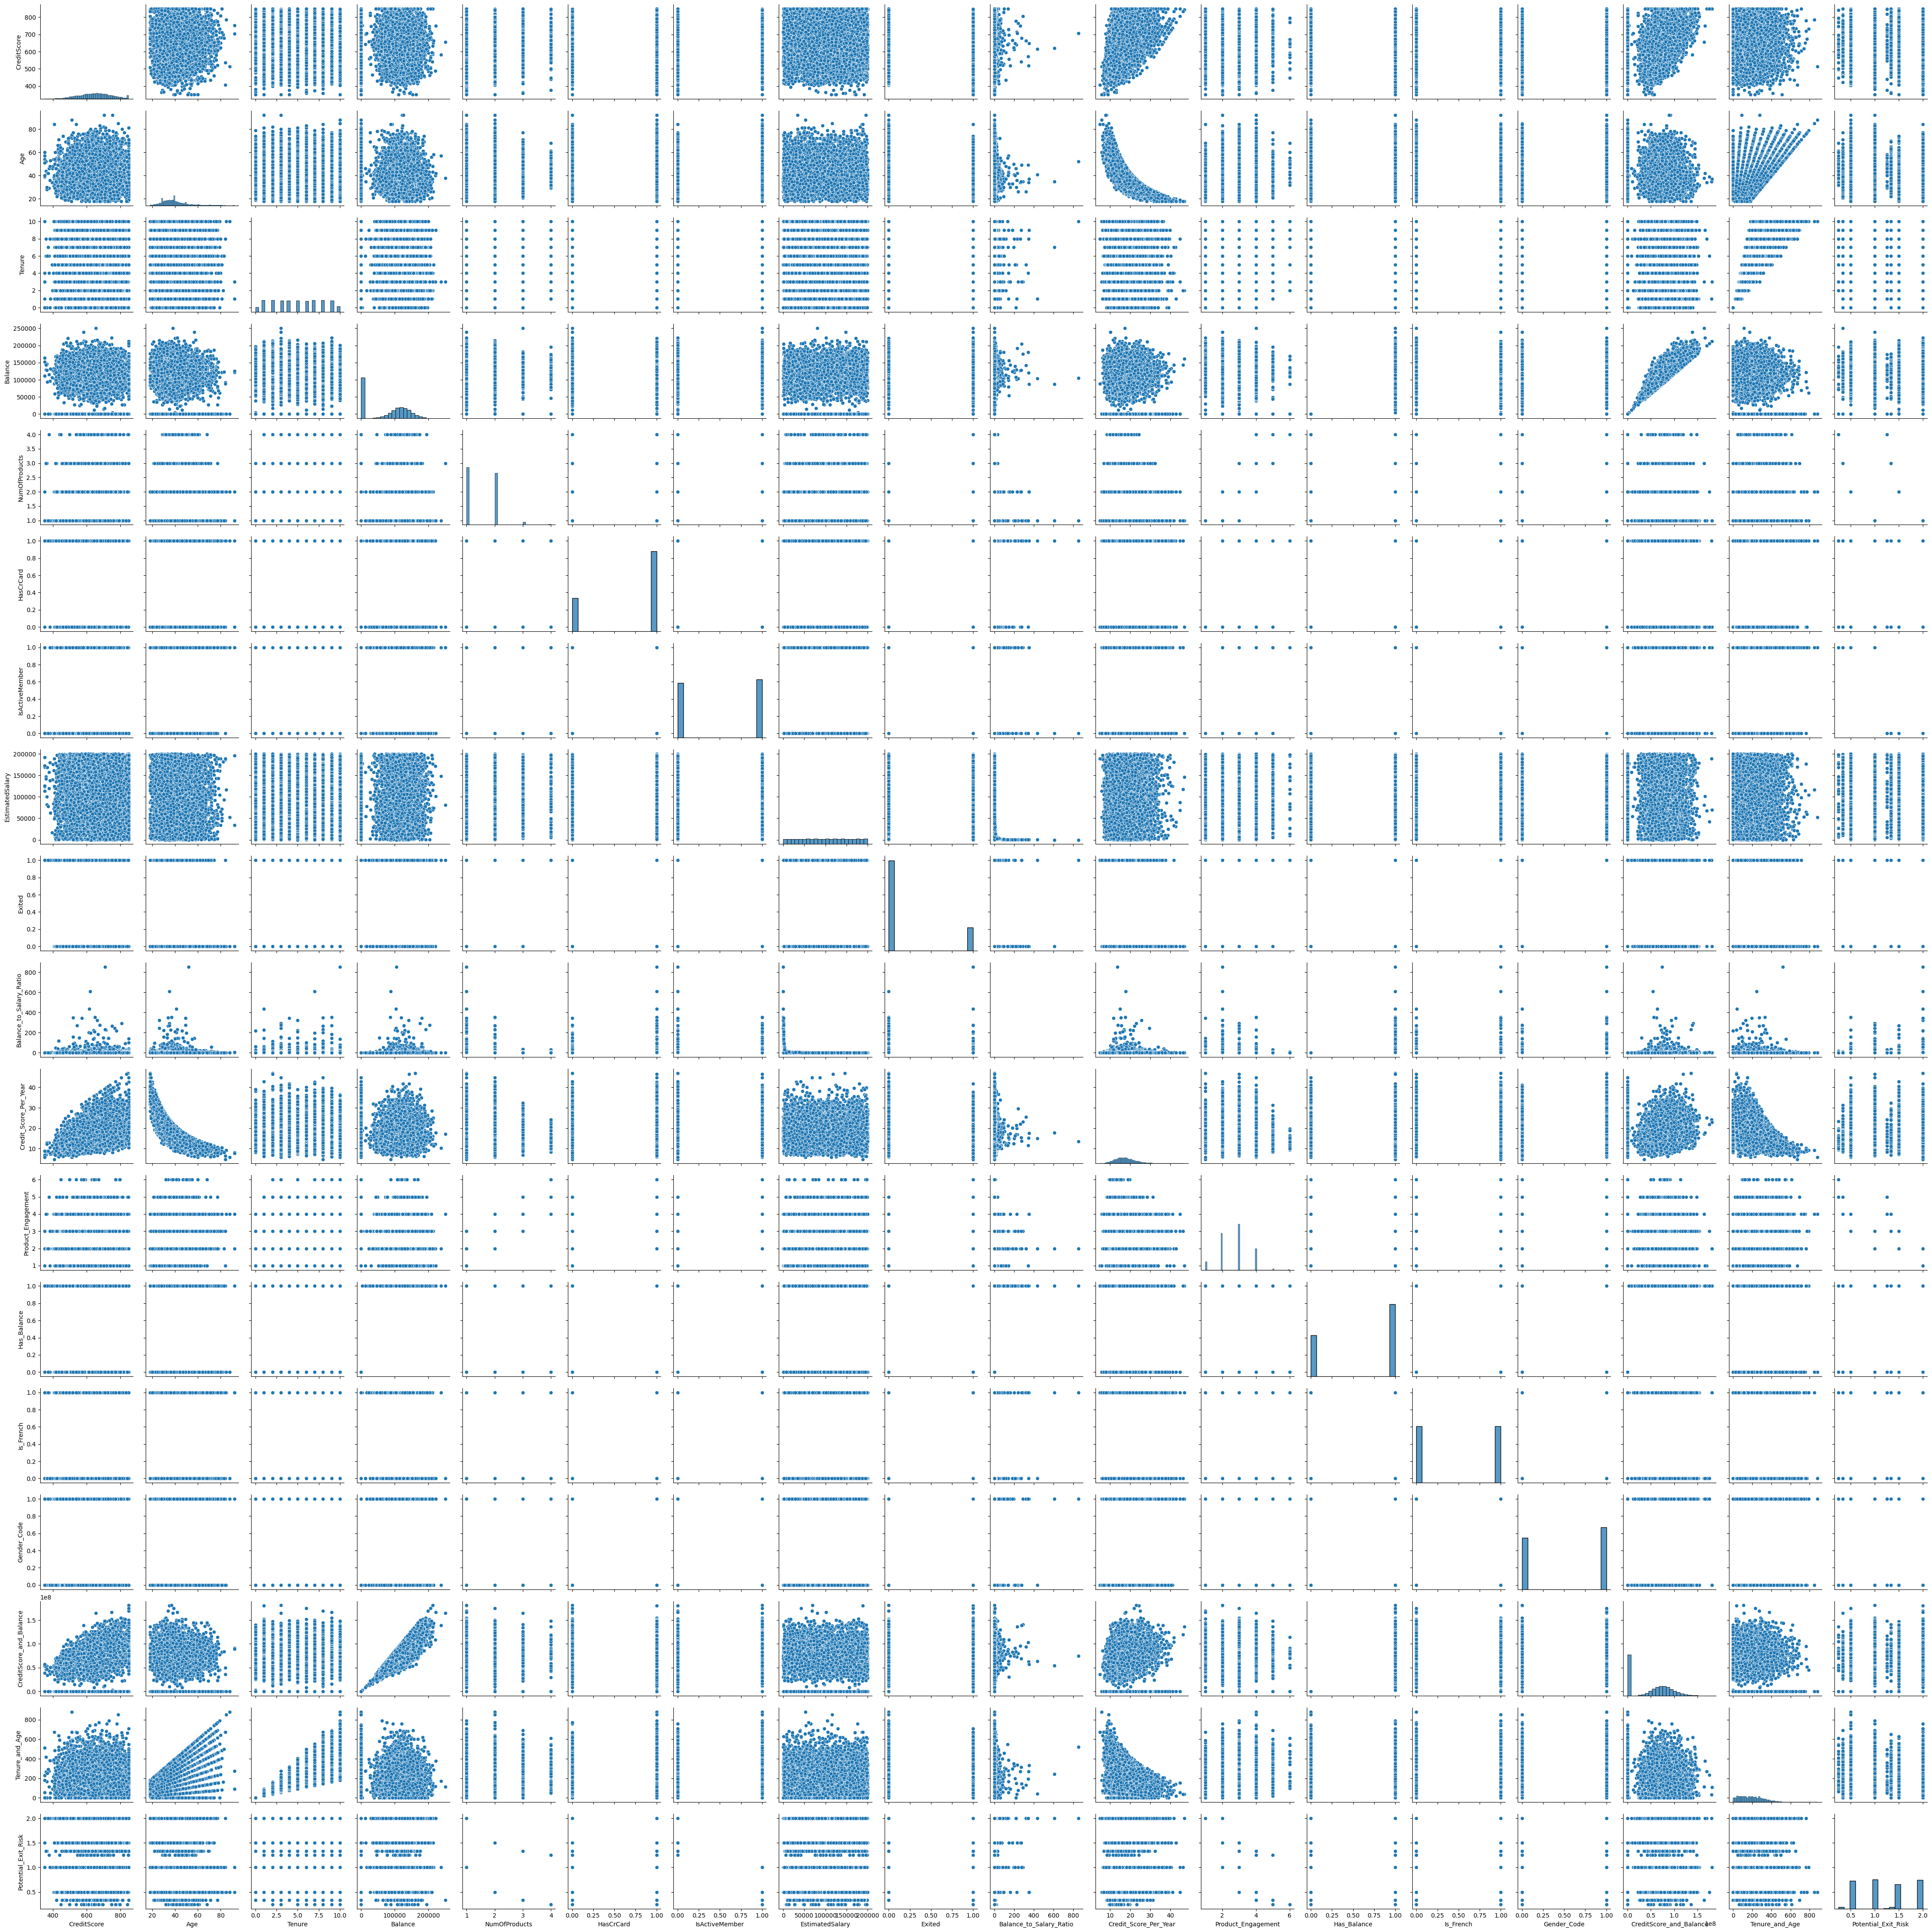

In [ ]:
# MultiVariate

sns.pairplot(df.select_dtypes(include='number'))

*************************************************

## (3) Pre-Processing Mind Map:
a) Detect & Handle Duplicates

b) train_test_split

c) Detect & Handle NaNs

d) Detect & Handle Outliers

e) Encoding: (Ordinal:[OrdinalEncoder, LabelEncoder] - Nominal: [< 7 uniques(OneHotEncoding), > 7 uniques (BinaryEncoder)])

f) Imbalanced: X_train_resampled

g) Scaling: StandardScaler, MinMaxScaler, RobustScaler: X_train_resampled_scaled



In [ ]:
# (a) Detect & Handle Duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France  Female   42       2       0.00              1   
1             608     Spain  Female   41       1   83807.86              1   
2             502    France  Female   42       8  159660.80              3   
3             699    France  Female   39       1       0.00              2   
4             850     Spain  Female   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9993          771    France    Male   39       5       0.00              2   
9994          516    France    Male   35      10   57369.61              1   
9995          709    France  Female   36       7       0.00              1   
9996          772   Germany    Male   42       3   75075.31              2   
9997          792    France  Female   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  ...  Age_Group Tenure_Group  \
0             1               1        101348.88  ...      Adult          New   
1             0               1        112542.58  ...      Adult          New   
2             1               0        113931.57  ...      Adult        Loyal   
3             0               0         93826.63  ...      Adult          New   
4             1               1         79084.10  ...      Adult          New   
...         ...             ...              ...  ...        ...          ...   
9993          1               0         96270.64  ...      Adult     Mid-Term   
9994          1               1        101699.77  ...      Adult        Loyal   
9995          0               1         42085.58  ...      Adult     Mid-Term   
9996          1               0         92888.52  ...      Adult          New   
9997          1               0         38190.78  ...      Adult     Mid-Term   

      CreditScore_Category  Product_Engagement Has_Balance Is_French  \
0                  Average                   3           0         1   
1                  Average                   2           1         0   
2                      Low                   4           1         1   
3                     Good                   2           0         1   
4                Excellent                   3           1         0   
...                    ...                 ...         ...       ...   
9993             Very Good                   3           0         1   
9994                   Low                   3           1         1   
9995                  Good                   2           0         1   
9996             Very Good                   3           1         0   
9997             Very Good                   2           1         1   

     Gender_Code  CreditScore_and_Balance  Tenure_and_Age  Potential_Exit_Risk  
0              0             0.000000e+00              84             1.000000  
1              0             5.095518e+07              41             1.000000  
2              0             8.014972e+07             336             1.333333  
3              0             0.000000e+00              39             1.500000  
4              0             1.066842e+08              86             1.000000  
...          ...                      ...             ...                  ...  
9993           1             0.000000e+00             195             1.500000  
9994           1             2.960272e+07             350             1.000000  
9995           0             0.000000e+00             252             1.000000  
9996           1             5.795814e+07             126             1.500000  
9997           0             1.030731e+08             112             2.000000  

[9998 rows x 24 columns]

In [ ]:
df['Exited'].value_counts(normalize=True)

Exited
0    0.796459
1    0.203541
Name: proportion, dtype: float64

In [ ]:
# (b) train_test_split

X = df.drop(["Exited"], axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
X_train

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
2572          689     Spain    Male   40       2       0.00              2   
4580          572    France  Female   47       2       0.00              2   
7567          422     Spain  Female   54       4       0.00              2   
6516          628   Germany  Female   51       9  155903.82              2   
6564          663    France  Female   33       2       0.00              2   
...           ...       ...     ...  ...     ...        ...            ...   
9216          676   Germany  Female   48       2  124442.38              1   
4643          712     Spain    Male   74       5       0.00              2   
8941          667    France  Female   37       9   71786.90              2   
2934          687     Spain    Male   35       8  100988.39              2   
6205          802     Spain    Male   51       7       0.00              1   

      HasCrCard  IsActiveMember  EstimatedSalary  ... Age_Group  Tenure_Group  \
2572          1               1        164768.82  ...     Adult           New   
4580          1               0         36099.70  ...     Adult           New   
7567          1               1          7166.71  ...     Adult      Mid-Term   
6516          1               1         71159.84  ...     Adult         Loyal   
6564          1               0        153295.00  ...     Adult           New   
...         ...             ...              ...  ...       ...           ...   
9216          1               0         15068.53  ...     Adult           New   
4643          0               0        151425.82  ...    Senior      Mid-Term   
8941          1               1         67734.79  ...     Adult         Loyal   
2934          1               0         22247.27  ...     Adult         Loyal   
6205          0               1         40855.79  ...     Adult      Mid-Term   

      CreditScore_Category Product_Engagement Has_Balance Is_French  \
2572                  Good                  4           0         0   
4580                   Low                  3           0         1   
7567                   Low                  4           0         0   
6516               Average                  4           1         0   
6564               Average                  3           0         1   
...                    ...                ...         ...       ...   
9216                  Good                  2           1         0   
4643                  Good                  2           0         0   
8941               Average                  4           1         1   
2934                  Good                  3           1         0   
6205             Excellent                  2           0         0   

      Gender_Code  CreditScore_and_Balance  Tenure_and_Age  \
2572            1                     0.00              80   
4580            0                     0.00              94   
7567            0                     0.00             216   
6516            0              97907598.96             459   
6564            0                     0.00              66   
...           ...                      ...             ...   
9216            0              84123048.88              96   
4643            1                     0.00             370   
8941            0              47881862.30             333   
2934            1              69379023.93             280   
6205            1                     0.00             357   

      Potential_Exit_Risk  
2572                  0.5  
4580                  1.5  
7567                  0.5  
6516                  0.5  
6564                  1.5  
...                   ...  
9216                  2.0  
4643                  1.5  
8941                  0.5  
2934                  1.5  
6205                  1.0  

[7998 rows x 23 columns]

In [ ]:
X_test.shape

(2000, 23)

In [ ]:
X_train.isna().sum()

CreditScore                0
Geography                  0
Gender                     0
Age                        0
Tenure                     0
Balance                    0
NumOfProducts              0
HasCrCard                  0
IsActiveMember             0
EstimatedSalary            0
products_engagment         0
Balance_to_Salary_Ratio    0
Credit_Score_Per_Year      0
Age_Group                  0
Tenure_Group               0
CreditScore_Category       0
Product_Engagement         0
Has_Balance                0
Is_French                  0
Gender_Code                0
CreditScore_and_Balance    0
Tenure_and_Age             0
Potential_Exit_Risk        0
dtype: int64

In [ ]:
y_train.value_counts()

Exited
0    6370
1    1628
Name: count, dtype: int64

In [ ]:
# pipline 
from sklearn.base import TransformerMixin, BaseEstimator


class LogTransformer(BaseEstimator, TransformerMixin):

    # fit
    def fit(self, X, y=None):
        # self.feature_names = list(X.columns)
        self.n_features_in = X.shape[1]
        return self

    # transformer
    def transform(self, X, y=None):
        assert self.n_features_in == X.shape[1]
        return np.log(X)

    def get_feature_names_out(self, X, y=None):
        return self.feature_names



log_transformer = LogTransformer()
log_transformer

LogTransformer()

In [ ]:
# * c) Detect & Handle NaNs
# * d) Detect & Handle Outliers
# * e) Encoding: (Ordinal:[OrdinalEncoder, LabelEncoder] - Nominal: [< 7 uniques(OneHotEncoding), > 7 uniques (BinaryEncoder)])
# * f) Scaling: StandardScaler, MinMaxScaler, RobustScaler: X_train_resampled_scaled
# * g) Imbalanced: X_train_resampled

""""
CreditScore: mean => no outliers =>
Geography: mode => OHE (uniques < 7)
Gender: mode => OHE
Age:  median => log
Tenure: mode => encoded
Balance: median => no outlier
NumOfProducts: mode => encoded
HasCrCard: mode => encoded
IsActiveMember: mode => encoded
EstimatedSalary: mean (irrelevent feat) =>
products_engagment: mode => Ordinal
"""

geo_gender_pipe = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(drop='first', sparse_output=False))
])

products_engage_pipe = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(categories=[['very_low_engagment', 'small_engagment', 'avg_engagment', 'above_avg_engagment', 'high_engagment']]))
])

tenure_products_cc_active_pipe = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='most_frequent'))
])

creditscore_estimated_pipe = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
])

age_pipe = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('handle_outliers', LogTransformer()),
    ('scale', RobustScaler()),
])

balance_pipe = Pipeline(steps=[
    ('handle_nans', SimpleImputer(strategy='median')),
    ('scale', RobustScaler()),
])



In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('geo_gender_pipe', geo_gender_pipe, ['Geography', 'Gender']),
    ('products_engage_pipe', products_engage_pipe, ['products_engagment']),
    ('tenure_products_cc_active_pipe', tenure_products_cc_active_pipe, ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']),
    ('creditscore_estimated_pipe', creditscore_estimated_pipe, ['CreditScore', 'EstimatedSalary']),
    ('age_pipe', age_pipe, ['Age']),
    ('balance_pipe', balance_pipe, ['Balance']),
])

preprocessor

ColumnTransformer(transformers=[('geo_gender_pipe',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Geography', 'Gender']),
                                ('products_engage_pipe',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encode',
                                                  OrdinalEncoder(categories=[['very_lo...
                                                  SimpleImputer()),
                                                 ('scale', StandardScaler())]),
                                 ['CreditScore', 'EstimatedSalary']),
                                ('age_pipe',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outliers',
                                                  LogTransformer()),
                                                 ('scale', RobustScaler())]),
                                 ['Age']),
                                ('balance_pipe',
                                 Pipeline(steps=[('handle_nans',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', RobustScaler())]),
                                 ['Balance'])])

In [ ]:
X_trian_scaled = preprocessor.fit_transform(X_train)
X_trian_scaled

array([[ 0.        ,  1.        ,  1.        , ...,  1.13596471,
         0.24481277, -0.76170152],
       [ 0.        ,  0.        ,  0.        , ..., -1.11046968,
         0.75122275, -0.76170152],
       [ 0.        ,  1.        ,  0.        , ..., -1.6156108 ,
         1.18719329, -0.76170152],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.55815259,
         0.        , -0.19990914],
       [ 0.        ,  1.        ,  1.        , ..., -1.35231928,
        -0.17449898,  0.02861688],
       [ 0.        ,  1.        ,  1.        , ..., -1.0274331 ,
         1.00770595, -0.76170152]])

In [ ]:
X_trian_scaled.shape

(7998, 12)

In [ ]:
X_test_scaled = preprocessor.transform(X_test)
X_test_scaled

array([[ 0.        ,  0.        ,  1.        , ..., -0.09464577,
        -0.08603754, -0.76170152],
       [ 1.        ,  0.        ,  1.        , ..., -0.77921602,
        -0.35926836,  0.26366871],
       [ 0.        ,  1.        ,  0.        , ...,  0.10002978,
         0.24481277, -0.76170152],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.87137965,
         0.75122275,  0.24234316],
       [ 0.        ,  0.        ,  1.        , ..., -1.4802969 ,
         0.16531046, -0.76170152],
       [ 0.        ,  0.        ,  1.        , ..., -0.49532375,
        -0.35926836,  0.43019433]])

***********************************************

## (4) Modeling



* (1) Simple Model & Validate it's perfromance



* (2) Underfitting vs Overfitting



* (3) Hyperparameters Tunning (best 5 Promissing models)



* (4) Ensemble (if needed)



* (5) Test Performance and it's CI



* (6) Save Model and load in streamlit application or flask application

In [ ]:
## (1) Simple Model & Validate it's perfromance

from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model
log_reg = LogisticRegression(random_state=42, C=1.0, max_iter=100, warm_start=True, class_weight='balanced')
log_reg.fit(X_trian_scaled, y_train)

In [ ]:
log_reg.score(X_trian_scaled, y_train)

In [ ]:
#y_valid_pred = cross_val_predict(log_reg, X_trian_scaled, y_train, cv=3)
#confusion_matrix(y_true=y_train, y_pred=y_valid_pred)
